[Dataset link](https://www.kaggle.com/code/lumenalux/balanced-dataset-in-h5-format-3-67gb)

In [4]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [5]:
def read_dataset(path="balanced_dataset.h5"):
    rf_dataset = pd.DataFrame()

    with h5py.File(path, 'r') as f:
        for cls in f.keys():
            df = pd.DataFrame({
                'snrs': np.array(f[f'{cls}/snrs']),
                'duty_cycle': np.array(f[f'{cls}/duty_cycle']),
                'x_iq': list(f[f'{cls}/x_iq']),
                'x_spec': list(f[f'{cls}/x_spec']),
                'y': np.array(f[f'{cls}/y']),
            })
            rf_dataset = pd.concat([rf_dataset, df], ignore_index=True)

    return rf_dataset


In [6]:
from typing import List
from scipy.stats import skew, kurtosis
from scipy.fft import fft


def extract_spectrogram_features(
        spectrogram:pd.Series
    ) -> List:
    '''
    Function to extract features from spectrogram
    Args:
        spectrogram: Series of spectrogram data

    Returns: [Mean value, Median value, STD, Skewness, Kurtosis]

    '''
    mean_val = np.mean(spectrogram)
    median_val = np.median(spectrogram)
    std_val = np.std(spectrogram)
    skewness = skew(spectrogram.flatten())
    kurt = kurtosis(spectrogram.flatten())
    return [mean_val, median_val, std_val, skewness, kurt]


def extract_iq_features(
        iq_data:pd.Series
    ) -> List:
    '''
    Function to extract features from iq 
    Args:
        iq_data: Series of iq data

    Returns:[Mean value, Median_value, STD, Skewness, Kurtosis, Dominant frequency, Variance of frequency]

    '''

    iq_features = []

    for channel in iq_data:
        mean_val = np.mean(channel)
        median_val = np.median(channel)
        std_val = np.std(channel)
        skewness = skew(channel)
        kurt = kurtosis(channel)

        freq_domain = fft(channel)
        dominant_freq = np.argmax(np.abs(freq_domain))
        freq_variance = np.var(np.abs(freq_domain))

        iq_features.extend([mean_val, median_val, std_val, skewness, kurt, dominant_freq, freq_variance])

    return iq_features


def create_feature_dataframe(x_iq:pd.Series,
                             x_spec:pd.Series,
                             y:pd.Series,
                             snrs:pd.Series,
                             duty_cycle:pd.Series
    ) -> pd.DataFrame:
    '''
    Creates a DataFrame from early extracted features of data
    Args:
        x_iq: 
        x_spec: 
        y: 
        snrs: 
        duty_cycle: 

    Returns:

    '''
    features = []
    for iq, spec, label, snr, duty, cl in zip(x_iq, x_spec, y, snrs, duty_cycle):
        spectrogram_features = extract_spectrogram_features(spec)
        iq_features = extract_iq_features(iq)
        features.append(spectrogram_features + iq_features + [snr, duty, label])

    columns = ['spec_mean', 'spec_median', 'spec_std', 'spec_skew', 'spec_kurt',
               'iq_mean_ch1', 'iq_median_ch1', 'iq_std_ch1', 'iq_skew_ch1', 'iq_kurt_ch1', 'iq_dom_freq_ch1', 'iq_freq_var_ch1',
               'iq_mean_ch2', 'iq_median_ch2', 'iq_std_ch2', 'iq_skew_ch2', 'iq_kurt_ch2', 'iq_dom_freq_ch2', 'iq_freq_var_ch2',
               'snr', 'duty_cycle', 'label']
    df = pd.DataFrame(features, columns=columns)
    return df


In [19]:
from typing import Tuple


def plot_input_data(spectrogram_2d,
                    iq_2d:pd.Series,
                    title:str='',
                    figsize:Tuple[int,int]=(10,9)
    )->None:
    '''
    Plot of the spectrogram and iq data
    Args:
        spectrogram_2d: 
        iq_2d: 
        title: 
        figsize: 

    Returns:

    '''
    fig, axs = plt.subplot_mosaic([['spec_re', 'spec_im'], ['spec_re', 'spec_im'], ['iq_re', 'iq_re'], ['iq_im', 'iq_im']], figsize=figsize)

    # plot spectrogram Re and Im
    spec_re = axs['spec_re'].imshow(spectrogram_2d[0,:,:]) #, aspect='auto', origin='lower')
    axs['spec_re'].set_title('Re', fontsize=10)
    fig.colorbar(spec_re, ax=axs['spec_re'], shrink=0.5)

    spec_im = axs['spec_im'].imshow(spectrogram_2d[1,:,:]) #, aspect='auto', origin='lower')
    axs['spec_im'].set_title('Im', fontsize=10)
    fig.colorbar(spec_im, ax=axs['spec_im'], shrink=0.5)

    # plot iq Re and Im
    axs['iq_re'].plot(iq_2d[0,:])
    axs['iq_re'].set_title('IQ data')
    axs['iq_re'].set_ylabel('Re', rotation=0)

    axs['iq_im'].plot(iq_2d[1,:])
    # axs['iq_im'].set_title('Im')
    axs['iq_im'].set_xlabel('Time (samples)')
    axs['iq_im'].set_ylabel('Im', rotation=0)
    
    plt.show()


## Graph of data sample

In [13]:
df = read_dataset()
df.head()

,snrs,duty_cycle,x_iq,x_spec,y
0,-18,1.000000,"[[-1.7037327, -0.99873316, -0.035902604, 0.219...","[[[0.01630933, -0.016540058, -0.006597518, -0....",0
1,-10,0.060547,"[[-0.2119061, -0.3759562, 1.4548285, -1.276124...","[[[-0.017251128, 0.0016958712, -0.0030887218, ...",0
2,-6,0.975769,"[[-0.25525343, 0.27856958, -0.26633498, 0.1205...","[[[-0.0025569443, 0.0074404734, 0.0022911315, ...",0
3,0,0.869324,"[[-0.3779635, -0.10132809, -0.24967794, 0.6035...","[[[-0.002177195, -0.00064718095, 0.0035892264,...",0
4,0,0.494568,"[[0.61507225, -0.5248958, -0.09456021, 0.37134...","[[[0.00097559235, 0.0018039008, 0.001442022, -...",0


In [20]:

sample_id = 100

y = df['y'][sample_id]
act_snr = df['snrs'][sample_id]
act_duty_cycle = df['duty_cycle'][sample_id]
plt_title = f'Sample# {sample_id}' + ', SNR: '+ str(act_snr) + 'dB, Duty Cycle: 1'
spectrogram_2d = list(df['x_spec'])[sample_id]
iq_2d = list(df['x_iq'])[sample_id]


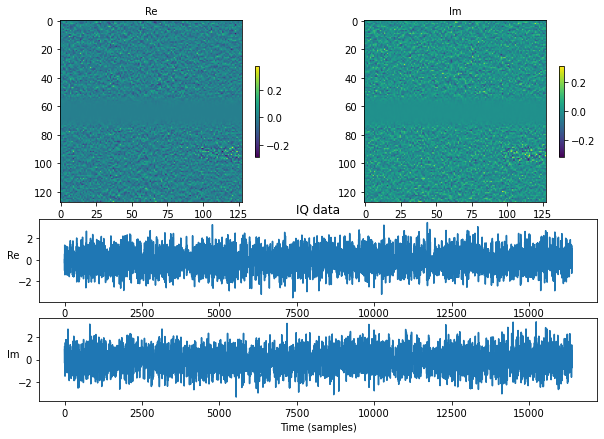

In [21]:
plot_input_data(spectrogram_2d, iq_2d, title=plt_title, figsize=(10,7))

In [26]:
#Creating the dataframe with rf features 
feature_df = create_feature_dataframe(df['x_iq'], df['x_spec'], df['y'], df['snrs'], df['duty_cycle'])


NameError: name 'df' is not defined

In [24]:
#Optional
del(df) # to free up space

In [25]:
feature_df.hist(figsize=(20,15), bins=20)

NameError: name 'feature_df' is not defined

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    feature_df.drop("label", axis=1), feature_df['label'], test_size=0.2, random_state=42)

NameError: name 'feature_df' is not defined

In [119]:
print(X_train.shape, y_train.shape)

(11200, 22) (11200,)


In [70]:
# Optional
# Normalizing data for numerical stability
from sklearn.preprocessing import StandardScaler

ss_train = StandardScaler()
X_train = ss_train.fit_transform(X_train)

ss_test = StandardScaler()
X_test = ss_test.fit_transform(X_test)


array([[ 4.61221931e-01, -1.52229602e-01,  6.75623667e-03, ...,
        -7.72573377e-02,  1.13638675e+00,  9.97280725e-01],
       [-6.36379429e-01,  7.02623281e-02, -5.10280790e-04, ...,
        -1.00866981e+00, -7.86066730e-01, -1.00174283e+00],
       [-3.77659108e-01,  2.59586445e-02,  2.45043491e-02, ...,
         1.88860510e-01,  1.29483434e+00, -1.00174283e+00],
       ...,
       [ 8.49014645e-02, -1.48459024e-01,  2.38144511e-02, ...,
        -8.75610882e-01,  1.15219857e+00, -5.01986942e-01],
       [-7.77499604e-01, -1.24618839e-01,  1.49168591e-02, ...,
        -1.54090550e+00, -6.53807464e-01, -1.50149872e+00],
       [ 2.27981642e-01,  5.23200000e-02,  2.81305944e-02, ...,
         9.87214054e-01,  1.29483434e+00, -2.23105307e-03]])

In [77]:
models = {}
history = {}
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression(max_iter=3000)

from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()

In [100]:
from sklearn.metrics import accuracy_score, precision_score, recall_score


accuracy, precision, recall = {}, {}, {}

for key in models.keys():

    # Fit the classifier
    models[key].fit(X_train, y_train)

    # Make predictions
    predictions = models[key].predict(X_test)

    # Calculate metrics
    accuracy[key] = accuracy_score(predictions, y_test)
    precision[key] = precision_score(predictions, y_test,average='micro')
    recall[key] = recall_score(predictions, y_test,average='micro')


C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [101]:
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()

df_model

,Accuracy,Precision,Recall
Logistic Regression,0.509286,0.509286,0.509286
Decision Trees,1.000000,1.000000,1.000000
Random Forest,0.999286,0.999286,0.999286


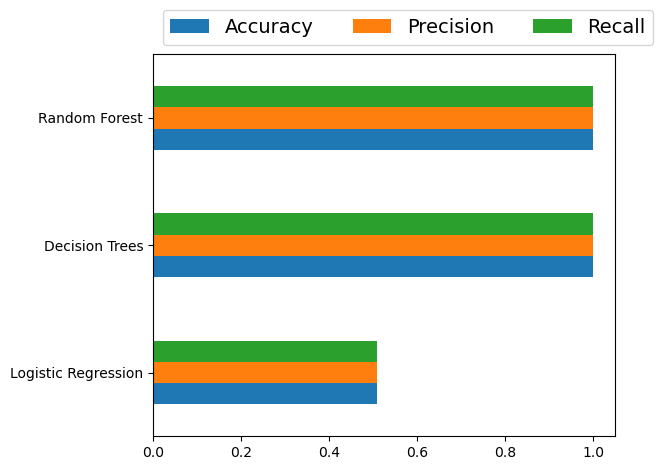

In [102]:
ax = df_model.plot.barh()
ax.legend(
    ncol=len(models.keys()),
    bbox_to_anchor=(0, 1),
    loc='lower left',
    prop={'size': 14}
)
plt.tight_layout()

C:\Users\user\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (14000).

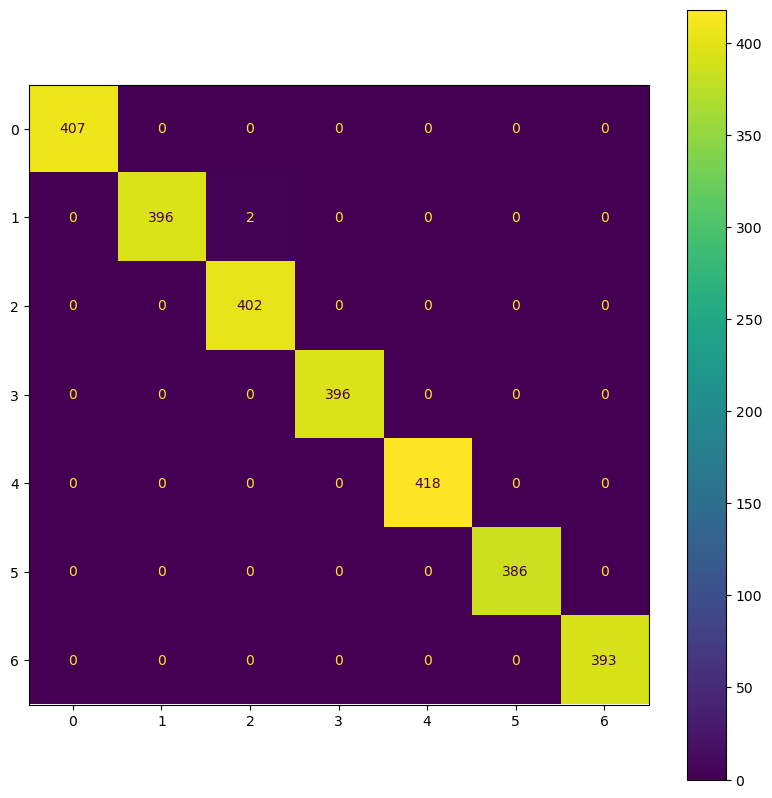

In [103]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

models['Logistic Regression'].fit(X_train, y_train)
predictions = models[key].predict(X_test)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feature_df['class'], )

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (14000).

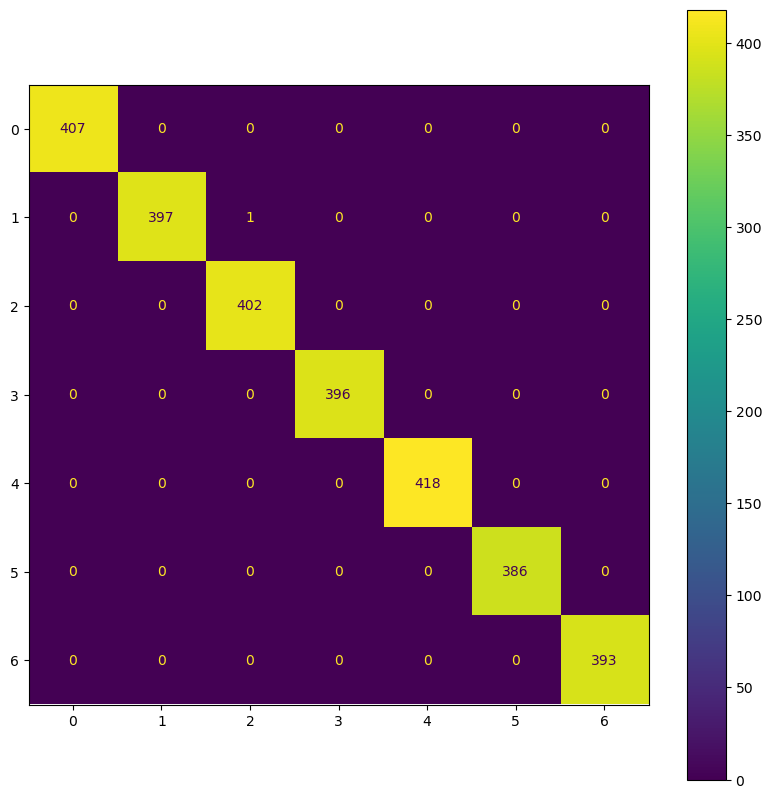

In [105]:
models['Random Forest'].fit(X_train, y_train)
predictions = models[key].predict(X_test)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feature_df['class'], )

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)


ValueError: The number of FixedLocator locations (7), usually from a call to set_ticks, does not match the number of labels (14000).

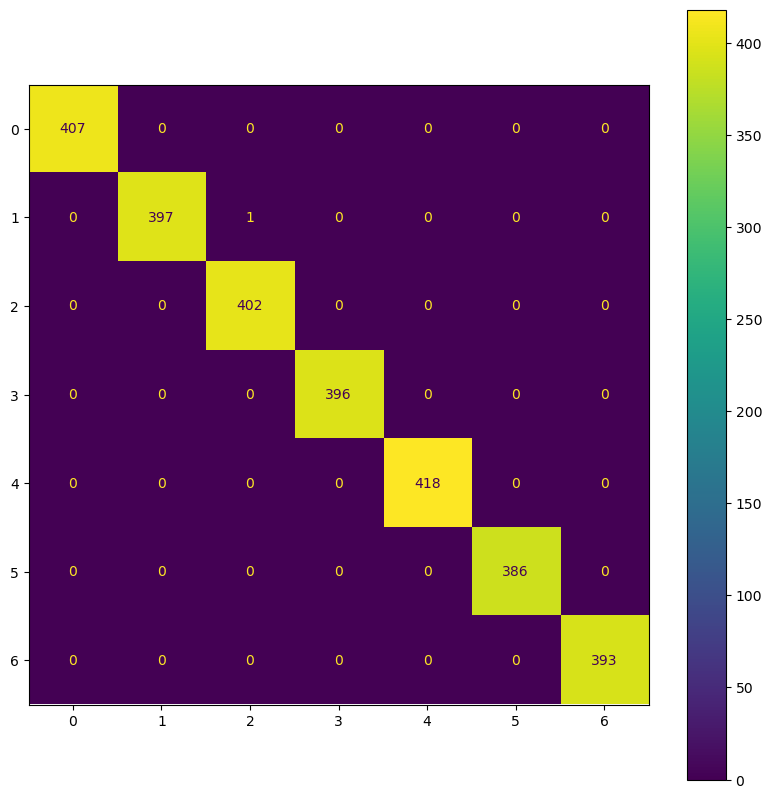

In [106]:
models['Decision Trees'].fit(X_train, y_train)
predictions = models[key].predict(X_test)

cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=feature_df['class'], )

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax)
